# Article summarization using Natural Language Processing (TextRank)
_By Lee Kai Yang_

References:
1. [Text Summarizer Using NLP advanced](https://www.kaggle.com/midouazerty/text-summarizer-using-nlp-advanced)
2. [Automatic paper writing based on RNN and the TextRank algorithm](https://doi.org/10.1016/j.asoc.2020.106767)

# 1. Setting up datasets and required libraries

In [45]:
# Importing the required libraries

import numpy as np
import pandas as pd
import warnings
import re
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
import string
from string import punctuation
from nltk.corpus import stopwords
from statistics import mean
from heapq import nlargest
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

# ntlk.download('stopwords')
# nltk.download('punkt')

stop_words = set(stopwords.words('english'))
punctuation = punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’'
warnings.filterwarnings('ignore')

In [27]:
# Importing the dataset
df_1 = pd.read_csv("../data/all-the-news/articles1.csv")
df_2 = pd.read_csv("../data/all-the-news/articles2.csv")
df_3 = pd.read_csv("../data/all-the-news/articles3.csv")

In [28]:
# Checking if the columns are same or not
print(df_1.columns == df_2.columns)
print(df_2.columns == df_3.columns)

[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]


In [29]:
# Combining them into one dataframe 
d = [df_1, df_2, df_3]
df = pd.concat(d, keys=['x', 'y', 'z'])
df.rename(columns= {'content': 'article'}, inplace=True)

In [30]:
df

Unnamed: 0      id  \
x 0               0   17283   
  1               1   17284   
  2               2   17285   
  3               3   17286   
  4               4   17287   
...             ...     ...   
z 42566      146028  218078   
  42567      146029  218079   
  42568      146030  218080   
  42569      146031  218081   
  42570      146032  218082   

                                                     title      publication  \
x 0      House Republicans Fret About Winning Their Hea...   New York Times   
  1      Rift Between Officers and Residents as Killing...   New York Times   
  2      Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   New York Times   
  3      Among Deaths in 2016, a Heavy Toll in Pop Musi...   New York Times   
  4      Kim Jong-un Says North Korea Is Preparing to T...   New York Times   
...                                                    ...              ...   
z 42566  An eavesdropping Uber driver saved his 16-year...  Washington Post   
  42567  Plane carrying six people returning from a Cav...  Washington Post   
  42568  After helping a fraction of homeowners expecte...  Washington Post   
  42569  Yes, this is real: Michigan just banned bannin...  Washington Post   
  42570  What happened in Washington state after voters...  Washington Post   

                                author        date    year  month  \
x 0                         Carl Hulse  2016-12-31  2016.0   12.0   
  1      Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0   
  2                       Margalit Fox  2017-01-06  2017.0    1.0   
  3                   William McDonald  2017-04-10  2017.0    4.0   
  4                      Choe Sang-Hun  2017-01-02  2017.0    1.0   
...                                ...         ...     ...    ...   
z 42566                       Avi Selk  2016-12-30  2016.0   12.0   
  42567                  Sarah Larimer  2016-12-30  2016.0   12.0   
  42568                    Renae Merle  2016-12-30  2016.0   12.0   
  42569                 Chelsea Harvey  2016-12-30  2016.0   12.0   
  42570           Christopher Ingraham  2016-12-29  2016.0   12.0   

                                                       url  \
x 0                                                    NaN   
  1                                                    NaN   
  2                                                    NaN   
  3                                                    NaN   
  4                                                    NaN   
...                                                    ...   
z 42566  https://web.archive.org/web/20161231004909/htt...   
  42567  https://web.archive.org/web/20161231004909/htt...   
  42568  https://web.archive.org/web/20161231004909/htt...   
  42569  https://web.archive.org/web/20161231004909/htt...   
  42570  https://web.archive.org/web/20161231004909/htt...   

                                                   article  
x 0      WASHINGTON  —   Congressional Republicans have...  
  1      After the bullet shells get counted, the blood...  
  2      When Walt Disney’s “Bambi” opened in 1942, cri...  
  3      Death may be the great equalizer, but it isn’t...  
  4      SEOUL, South Korea  —   North Korea’s leader, ...  
...                                                    ...  
z 42566           Uber driver Keith Avila picked up a p...  
  42567           Crews on Friday continued to search L...  
  42568       When the Obama administration announced a...  
  42569       This story has been updated. A new law in...  
  42570       The nation’s first recreational marijuana...  

[142570 rows x 10 columns]

In [31]:
# Shape of the dataset
print("The shape of the dataset: ", df.shape)

The shape of the dataset:  (142570, 10)


In [32]:
# Dropping the unnecessary columns
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

id                                              title     publication  \
x 0  17283  House Republicans Fret About Winning Their Hea...  New York Times   
  1  17284  Rift Between Officers and Residents as Killing...  New York Times   
  2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...  New York Times   
  3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...  New York Times   
  4  17287  Kim Jong-un Says North Korea Is Preparing to T...  New York Times   

                            author        date    year  month  url  \
x 0                     Carl Hulse  2016-12-31  2016.0   12.0  NaN   
  1  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0  NaN   
  2                   Margalit Fox  2017-01-06  2017.0    1.0  NaN   
  3               William McDonald  2017-04-10  2017.0    4.0  NaN   
  4                  Choe Sang-Hun  2017-01-02  2017.0    1.0  NaN   

                                               article  
x 0  WASHINGTON  —   Congressional Republicans have...  
  1  After the bullet shells get counted, the blood...  
  2  When Walt Disney’s “Bambi” opened in 1942, cri...  
  3  Death may be the great equalizer, but it isn’t...  
  4  SEOUL, South Korea  —   North Korea’s leader, ...

[Text(0.5, 0, 'Publication'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of publication')]

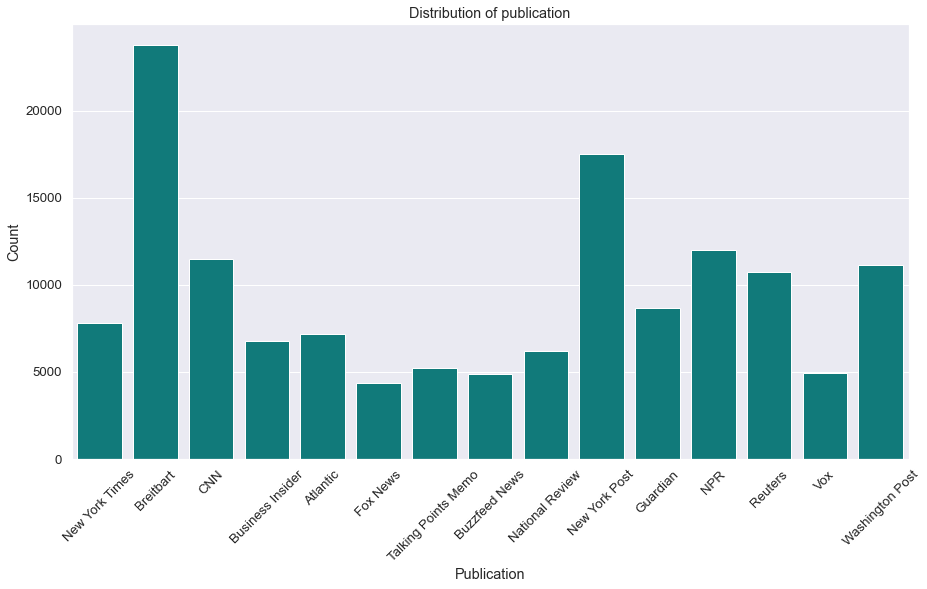

In [34]:
# Shows the distribution of publication
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale=1.2, style='darkgrid')
sns_year = sns.countplot(df['publication'], color='darkcyan')
plt.xticks(rotation=45)
sns_year.set(xlabel='Publication', ylabel='Count', title='Distribution of publication')

## 2. Exploratory Data Analysis

In [35]:
# Replacing the unnecessary row value of year with it's actual values
df['year'] = df['year'].replace("https://www.washingtonpost.com/outlook/tale-of-a-woman-who-died-and-a-woman-who-killed-in-the-northern-ireland-conflict/2019/03/08/59e75dd4-2ecd-11e9-8ad3-9a5b113ecd3c_story.html", 2019)

In [36]:
# Years
df['year'].value_counts()

2016.0    85405
2017.0    50404
2015.0     3705
2013.0      228
2014.0      125
2012.0       34
2011.0        8
2010.0        6
2008.0        3
2009.0        3
2004.0        2
2003.0        2
2005.0        2
2007.0        1
2000.0        1
Name: year, dtype: int64

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of the articles')]

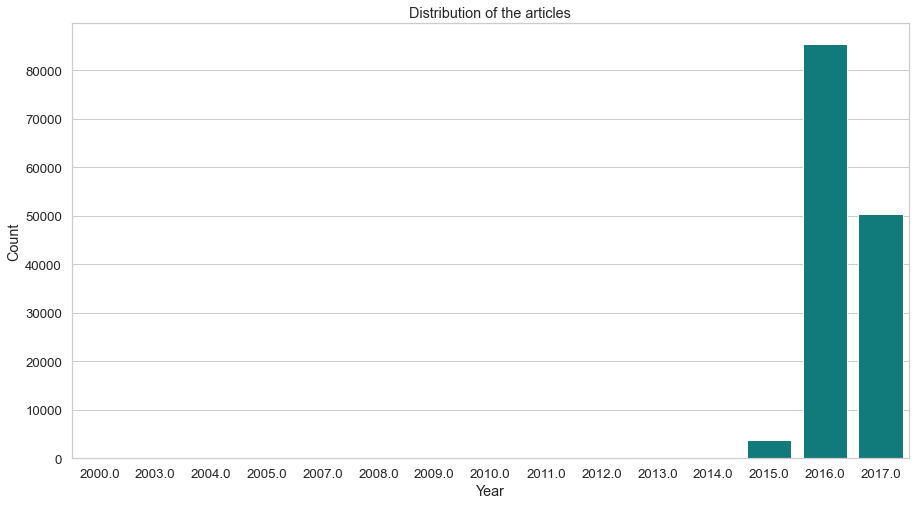

In [37]:
# Shows the distribution of the articles according to the year
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'whitegrid')
sns_year = sns.countplot(df['year'], color = 'darkcyan')
sns_year.set(xlabel = "Year", ylabel = "Count", title = "Distribution of the articles")

In [38]:
# Authors
df['author'].value_counts()

Breitbart News                                         1559
Pam Key                                                1282
Associated Press                                       1231
Charlie Spiering                                        928
Jerome Hudson                                           806
                                                       ... 
Laura Italiano, Sophia Rosenbaum and Philip Messing       1
Larry Celona, C.J. Sullivan and Daniel Prendergast        1
Krit McClean                                              1
Melissa Klein and Joe Tacopino                            1
John Yearwood                                             1
Name: author, Length: 15647, dtype: int64

[Text(0.5, 21.200000000000003, 'Count'),
 Text(21.200000000000003, 0.5, 'Author'),
 Text(0.5, 1.0, 'the most frequent author')]

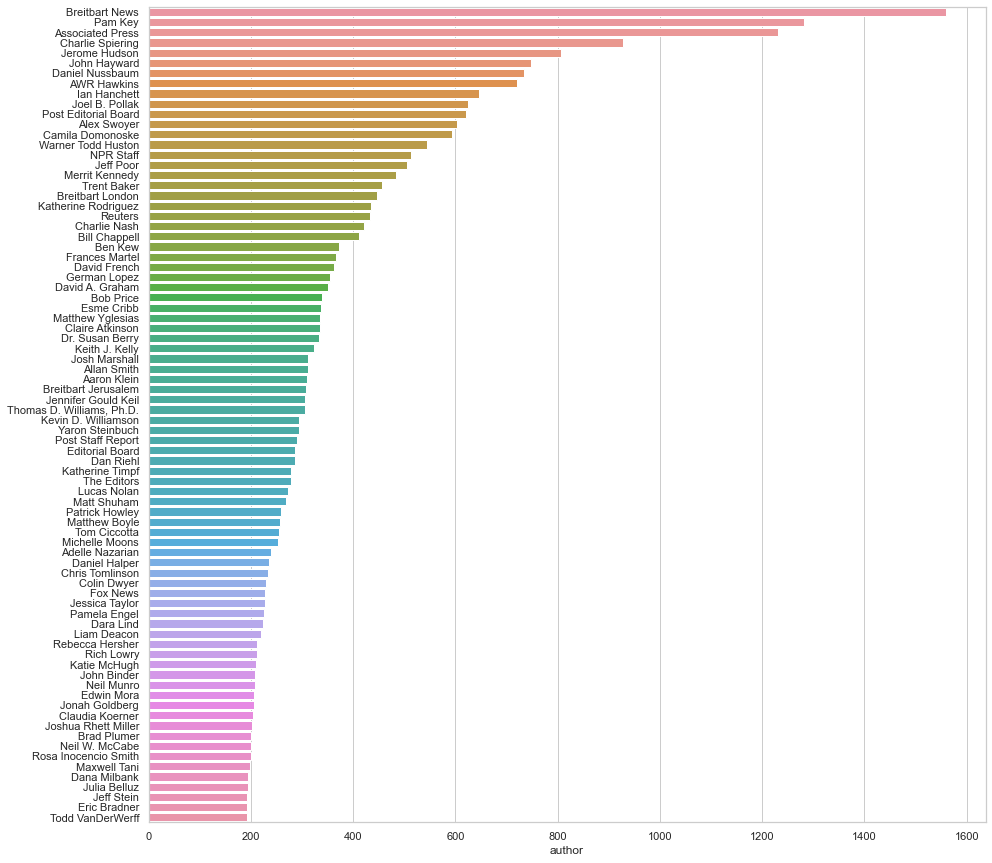

In [40]:
# Shows the distribution of author
plt.rcParams['figure.figsize'] = [15, 15]
sns.set(font_scale=1, style='whitegrid')
df_author = df.author.value_counts().head(80)

sns.barplot(df_author, df_author.index)
sns_year.set(xlabel='Count', ylabel='Author', title='the most frequent author')

In [41]:
# Changing the value "The Associated Press" to "Associated Press"
df['author'] = df['author'].replace("The Associated Press", "Associated Press")

## 3. Making the article summarizer

In [42]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function to clean the html from the article
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

# Function to preprocess the articles
def preprocessing(article):
    global article_sent
    
    # Converting to lowercase
    article = article.str.lower()
    
    # Removing the HTML
    article = article.apply(lambda x: cleanhtml(x))
    
    # Removing the email ids
    article = article.apply(lambda x: re.sub('\S+@\S+','', x))
    
    # Removing The URLS
    article = article.apply(lambda x: re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?",'', x))
    
    # Removing the '\xa0'
    article = article.apply(lambda x: x.replace("\xa0", " "))
    
    # Removing the contractions
    article = article.apply(lambda x: expand_contractions(x))

    # Stripping the possessives
    article = article.apply(lambda x: x.replace("'s", ''))
    article = article.apply(lambda x: x.replace('’s', ''))
    article = article.apply(lambda x: x.replace("\'s", ''))
    article = article.apply(lambda x: x.replace("\’s", ''))
    
    # Removing the Trailing and leading whitespace and double spaces
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Copying the article for the sentence tokenization
    article_sent = article.copy()
    
    # Removing punctuations from the article
    article = article.apply(lambda x: ''.join(word for word in x if word not in punctuation))
    
    # Removing the Trailing and leading whitespace and double spaces again as removing punctuation might
    # Lead to a white space
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Removing the Stopwords
    article = article.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    
    return article

# Function to normalize the word frequency which is used in the function word_frequency
def normalize(li_word):
    global normalized_freq
    normalized_freq = []
    for dictionary in li_word:
        max_frequency = max(dictionary.values())
        for word in dictionary.keys():
            dictionary[word] = dictionary[word]/max_frequency
        normalized_freq.append(dictionary)
    return normalized_freq

# Function to calculate the word frequency
def word_frequency(article_word):
    word_frequency = {}
    li_word = []
    for sentence in article_word:
        for word in word_tokenize(sentence):
            if word not in word_frequency.keys():
                word_frequency[word] = 1
            else:
                word_frequency[word] += 1
        li_word.append(word_frequency)
        word_frequency = {}
    normalize(li_word)
    return normalized_freq

# Function to Score the sentence which is called in the function sent_token
def sentence_score(li):
    global sentence_score_list
    sentence_score = {}
    sentence_score_list = []
    for list_, dictionary in zip(li, normalized_freq):
        for sent in list_:
            for word in word_tokenize(sent):
                if word in dictionary.keys():
                    if sent not in sentence_score.keys():
                        sentence_score[sent] = dictionary[word]
                    else:
                        sentence_score[sent] += dictionary[word]
        sentence_score_list.append(sentence_score)
        sentence_score = {}
    return sentence_score_list

# Function to tokenize the sentence
def sent_token(article_sent):
    sentence_list = []
    sent_token = []
    for sent in article_sent:
        token = sent_tokenize(sent)
        for sentence in token:
            token_2 = ''.join(word for word in sentence if word not in punctuation)
            token_2 = re.sub(' +', ' ',token_2)
            sent_token.append(token_2)
        sentence_list.append(sent_token)
        sent_token = []
    sentence_score(sentence_list)
    return sentence_score_list

# Function which generates the summary of the articles (This uses the 20% of the sentences with the highest score)
def summary(sentence_score_OwO):
    summary_list = []
    for summ in sentence_score_OwO:
        select_length = int(len(summ)*0.25)
        summary_ = nlargest(select_length, summ, key = summ.get)
        summary_list.append(".".join(summary_))
    return summary_list

# Functions to change the article string (if passed) to change it to generate a pandas series
def make_series(art):
    global dataframe
    data_dict = {'article' : [art]}
    dataframe = pd.DataFrame(data_dict)['article']
    return dataframe

# Function which is to be called to generate the summary which in further calls other functions alltogether
def article_summarize(artefact):
    
    if type(artefact) != pd.Series:
        artefact = make_series(artefact)
    
    df = preprocessing(artefact)
    
    word_normalization = word_frequency(df)
    
    sentence_score_OwO = sent_token(article_sent)
    
    summarized_article = summary(sentence_score_OwO)
    
    return summarized_article

In [46]:
# Generating the Word Cloud of the article using the preprocessing and make_series function mentioned below
def word_cloud(art):
    art_ = make_series(art)
    OwO = preprocessing(art_)
    wordcloud_ = WordCloud(height = 500, width = 1000, background_color = 'white').generate(art)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis('off');

# Generating the summaries for the first 100 articles
summaries = article_summarize(df['article'][0:100])

In [47]:
print ("The Actual length of the article is : ", len(df['article'][0]))
df['article'][0]

The Actual length of the article is :  5607


'WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been 

In [48]:
print ("The length of the summarized article is : ", len(summaries[0]))
summaries[0]

The length of the summarized article is :  1682


'anticipating that the trump administration might not be inclined to mount a vigorous fight against the house republicans given the dim view of the health care law a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program.the incoming trump administration could choose to no longer defend the executive branch against the suit which challenges the administration authority to spend billions of dollars on health insurance subsidies for and americans handing house republicans a big victory on issues. in a potentially decision in 2015 judge rosemary m collyer ruled that house republicans had the standing to sue the executive branch over a spending dispute and that the obama administration had been distributing the health insurance subsidies in violation of the constitution without approval from congress.in their request the lawyers predicted that a deal between house republicans and the new administration to dismiss or settle the ca